In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.signal as signal
from importlib import reload
import lib
import pymaster as nmt

In [2]:
def create_pixels():
    #Hardcoded for nside 128, lol
    row_width = 200 #pixels
    offset = 312
    start = 35000
    nrows = 200
    
    pixels_lr = np.array([np.arange(start+i*(offset+row_width), start+row_width+i*(offset+row_width)) for i in range(nrows)])
    pixels_ud = np.copy(pixels_lr.T)
    
    for pixels in (pixels_lr, pixels_ud):
        pixels[::2] = pixels[::2, ::-1] #flip even rows
        
    return np.concatenate(pixels_lr), np.concatenate(pixels_ud)

In [3]:
def PT(y, pixels, npix):
    return np.bincount(pixels, y, minlength=npix)

def PTP(pixels, npix):
    return np.bincount(pixels, minlength=npix)

In [4]:
def generate_noise(nsamp, dt, fknee, alpha, sigma):
    freq = np.abs(np.fft.fftfreq(nsamp, dt))
    noise_spec = (1+(np.maximum(freq,freq[1])/fknee)**-alpha)*sigma**2
#     plt.loglog(freq, noise_spec)
#     plt.grid()
#     plt.show()
    rand = np.fft.fft(np.random.default_rng().standard_normal(nsamp))
    return np.fft.ifft(rand * noise_spec**0.5).real

In [5]:
def subscan_polyfilter(times, tod, n_sub=200, deg=10):
    subscans = np.array_split(np.copy(tod), n_sub)
    subscans_times = np.array_split(times, n_sub)
    for time, scan in zip(subscans_times, subscans):
        poly = np.polynomial.polynomial.Polynomial.fit(time, scan, deg)
        scan -= poly(time)
    return np.concatenate(subscans)

In [6]:
def map_sim(input_map, pixels, rate, noise_params, subscan_poly_deg=10, replace=False, plot=True):
    nside = 128
    npix = 12*nside**2
    nsamp = len(pixels)    
    times = np.linspace(0, nsamp/rate, nsamp)

    signal = input_map[pixels]
    noise = np.zeros_like(signal)
    
    if noise_params is not None:
        fknee, alpha, sigma = noise_params
        noise = generate_noise(nsamp, 1/rate, fknee, alpha, sigma)
        
    tod = signal + noise
    filtered_tod = subscan_polyfilter(times, tod, n_sub=200, deg=subscan_poly_deg)
    
    if replace:
        m_planck = hp.smoothing(input_map, sigma=np.deg2rad(0.5)) 
        planck_tod = m_planck[pixels]
        filtered_planck_tod = subscan_polyfilter(times, planck_tod, n_sub=200, deg=subscan_poly_deg)
        lost_signal = planck_tod - filtered_planck_tod
        filtered_tod += lost_signal
        
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15, 5))
        ax[0].plot(times, tod, label='unfiltered', alpha=0.75)
        ax[0].plot(times, filtered_tod, label='filtered', alpha=0.75)
        ax[0].plot(times, signal, label='signal', alpha=0.75)
        ax[0].grid()
        
        _,_=ax[1].psd(tod, NFFT=2**12, Fs=rate, label='unfiltered', alpha=0.75)
        _,_=ax[1].psd(filtered_tod, NFFT=2**12, Fs=rate, label='filtered', alpha=0.75)
        _,_=ax[1].psd(signal, NFFT=2**12, Fs=rate,label='signal', alpha=0.75)
        ax[1].loglog()

        for a in ax:
            a.legend()
            
    output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)
    output_map[np.isnan(output_map)] = 0
    
    return output_map

In [7]:
def simulate_cross_spectra(input_cl, n_obs, noise_params, replace=False):
    input_map = hp.synfast(input_cl, nside=128)
    npix = 12*hp.get_nside(input_map)**2 
    coadd_map1 = np.zeros(npix)
    coadd_map2 = np.zeros(npix)

    for i in range(n_obs):
        coadd_map1 += map_sim(input_map, pixels_lr, rate, noise_params, subscan_poly_deg=10, replace=replace, plot=False)
        coadd_map1 += map_sim(input_map, pixels_ud, rate, noise_params, subscan_poly_deg=10, replace=replace, plot=False)
        
        coadd_map2 += map_sim(input_map, pixels_lr, rate, noise_params, subscan_poly_deg=10, replace=replace, plot=False)
        coadd_map2 += map_sim(input_map, pixels_ud, rate, noise_params, subscan_poly_deg=10, replace=replace, plot=False)

    coadd_map1 /= 2*n_obs
    coadd_map2 /= 2*n_obs

    cross_cl, ells = power_spectrum(mask_apo, coadd_map1, coadd_map2)
    
    return cross_cl[0], ells

In [8]:
def power_spectrum(mask_apo, m1, m2=None, bin_size=4):    
    nside = hp.get_nside(mask)
    b = nmt.NmtBin.from_nside_linear(nside, bin_size)
    ells = b.get_effective_ells()

    f = nmt.NmtField(mask_apo, [m1])
    if m2 is None:
        cl = nmt.compute_full_master(f, f, b)
    else:
        g = nmt.NmtField(mask_apo, [m2])
        cl = nmt.compute_full_master(f, g, b)
    
    return cl, ells

In [9]:
def full_sim(input_cl, n_sims, noise_params=(0.5,2,100), replace=False):
    cl = []
    for i in range(n_sims):
        cross_cl, ells = simulate_cross_spectra(input_cl, n_obs=10, noise_params=noise_params, replace=replace)
        cl.append(cross_cl)

    cl_mean = np.mean(cl, axis=0)
    cl_std = np.std(cl, axis=0)
    
    return ells, cl_mean, cl_std

/tmp/ipykernel_30473/841299649.py:3: RuntimeWarning: invalid value encountered in true_divide
  input_cl /= ell*(ell+1)/2/np.pi


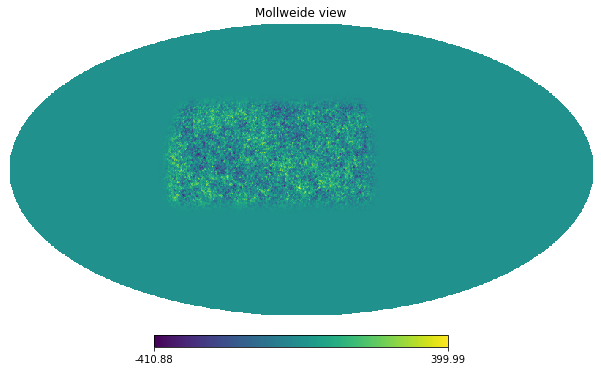

In [10]:
ell, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
input_cl = np.array([TT, TE, EE, BB])
input_cl /= ell*(ell+1)/2/np.pi 
for c in input_cl: c[0] = 0

nside = 128
lmax = 3*nside-1
npix = 12*nside**2
pixels_lr, pixels_ud = create_pixels()
rate = 10 #hz

TT = input_cl[0]
input_map = hp.synfast(TT, nside)
mask = np.zeros(npix)
mask[pixels_lr] = 1
mask_apo = nmt.mask_apodization(mask, 2.5, apotype="Smooth")    
hp.mollview(mask_apo * input_map)

/tmp/ipykernel_30473/3047093277.py:39: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)
/tmp/ipykernel_30473/3047093277.py:39: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)


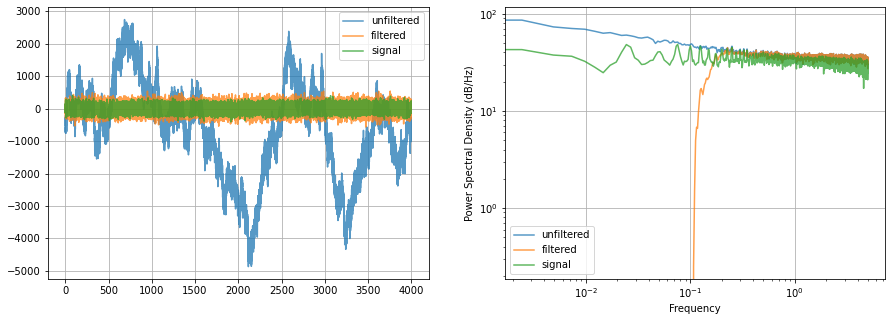

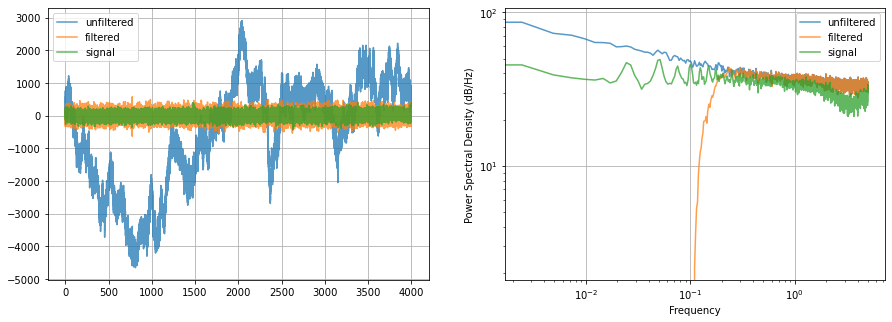

In [11]:
output_map1 = map_sim(input_map, pixels_lr, rate, noise_params=(0.5,2,100), subscan_poly_deg=10, plot=True, replace=False)
output_map2 = map_sim(input_map, pixels_ud, rate, noise_params=(0.5,2,100), subscan_poly_deg=10, plot=True, replace=False)

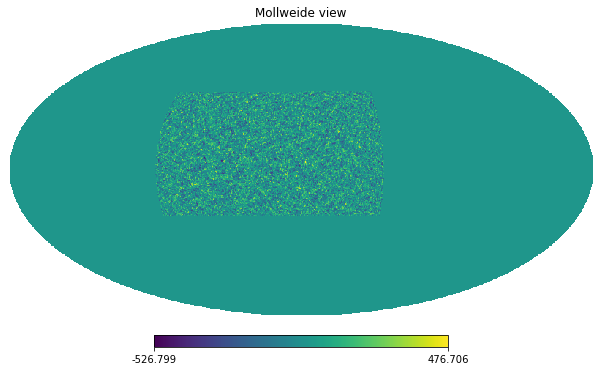

In [12]:
output_map = (output_map1 + output_map2)/2
hp.mollview(output_map)

In [13]:
n_sims = 10
ells, cl_filterbin_mean, cl_filterbin_std = full_sim(TT, n_sims, replace=False)
ells, cl_filterreplace_mean, cl_filterreplace_std = full_sim(TT, n_sims, replace=True)

/tmp/ipykernel_30473/3047093277.py:39: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)


In [15]:
nsims_FT = 100
ells, cl_FT_mean, cl_FT_std = full_sim(input_cl=np.ones(lmax+1), n_sims=nsims_FT, replace=False, noise_params=None)

/tmp/ipykernel_30473/3047093277.py:39: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)


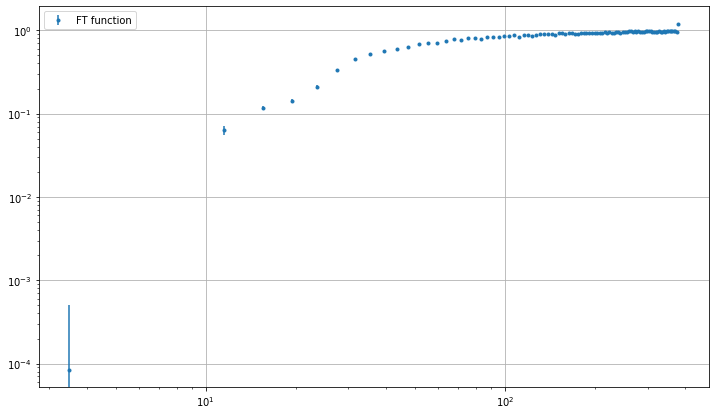

In [16]:
plt.figure(figsize=(12,7))
plt.errorbar(ells, cl_FT_mean, cl_FT_std/np.sqrt(nsims_FT), fmt='.', label='FT function')
plt.loglog()
plt.grid()
plt.legend()

(0.01, 1000.0)

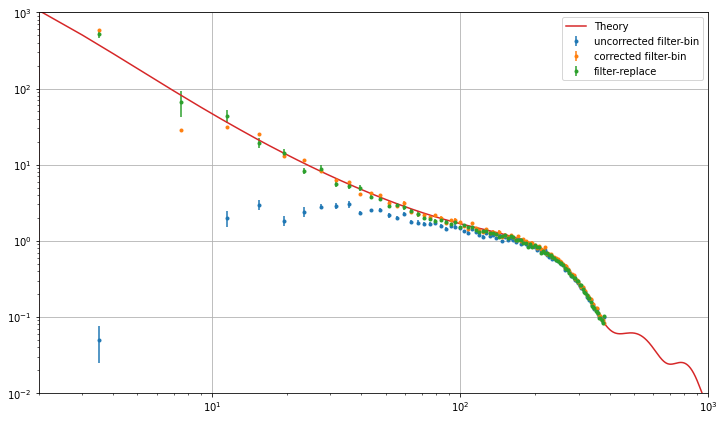

In [17]:
plt.figure(figsize=(12,7))
plt.errorbar(ells, cl_filterbin_mean, 2*cl_filterbin_std/np.sqrt(n_sims), fmt='.', label='uncorrected filter-bin')
plt.errorbar(ells, cl_filterbin_mean/cl_FT_mean, 2*cl_filterbin_std/np.sqrt(n_sims), fmt='.', label='corrected filter-bin')
plt.errorbar(ells, cl_filterreplace_mean, cl_filterreplace_std/np.sqrt(n_sims), fmt='.', label='filter-replace')
plt.plot(ell, input_cl[0], label='Theory')
plt.loglog()
plt.grid()
plt.legend()
plt.xlim([2e0,1e3])
plt.ylim([1e-2,1e3])